In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm


import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [45]:
df = pd.read_excel("M&D Intern Application Dataset Sample.xlsx",engine='openpyxl')
df.head()

,month,music_id,geo_country,total_play30s,total_downloads,total_favorites,total_playlist_adds,total_reposts,song_name,artist_name,upload_url,artist_url
0,2024-12-01,28573189,NG,9877,1585,99,313,5,IYAWO IRE,Saoty Arewa,http://audiomack.com/naijatram/song/saoty-arew...,http://audiomack.com/naijatram
1,2024-12-01,10591131,NG,7630,1326,65,243,5,90s&2000s HIPHOP PARTY MIX VOL1,DJ TONIOLY,http://audiomack.com/toniolyofficial/song/90s2...,http://audiomack.com/toniolyofficial
2,2024-12-01,38287359,NG,11131,2674,59,53,0,Relate,Sultin Shadow,http://audiomack.com/sultin_shadow/song/relate...,http://audiomack.com/sultin_shadow
3,2024-12-01,25135365,NG,5190,769,23,65,1,Osondi Owendi,MC Loph,http://audiomack.com/abundancex/song/osondi-ow...,http://audiomack.com/abundancex
4,2024-12-01,18655220,JM,17318,3873,55,314,2,Don Dada,Squash,http://audiomack.com/squashgcity1/song/don-dada,http://audiomack.com/squashgcity1


In [47]:
df.dtypes

,0
month,datetime64[ns]
music_id,int64
geo_country,object
total_play30s,int64
total_downloads,int64
total_favorites,int64
total_playlist_adds,int64
total_reposts,int64
song_name,object
artist_name,object


# Data Cleaning

In [50]:
df['song_name'] = df['song_name'].astype(str)
df['artist_name'] = df['artist_name'].astype(str)
df['geo_country'] = df['geo_country'].astype(str)
df['upload_url'] = df['upload_url'].astype(str)
df['artist_url'] = df['artist_url'].astype(str)

In [51]:
print(df['song_name'].apply(type).unique())
print(df['artist_name'].apply(type).unique())


[<class 'str'>]
[<class 'str'>]


In [52]:
print(df['geo_country'].apply(type).unique())
print(df['upload_url'].apply(type).unique())
print(df['artist_url'].apply(type).unique())


[<class 'str'>]
[<class 'str'>]
[<class 'str'>]


In [53]:
print(df['total_play30s'].apply(type).unique())

[<class 'int'>]


In [54]:
df.sort_values(by=['month'], inplace=True)

In [57]:
### adding region column

region_mapping = {
    "CA": "North America", "US": "North America",
    "GB": "Europe", "FR": "Europe", "DE": "Europe", "ES": "Europe", "IT": "Europe", "NL": "Europe",
    "NG": "Sub-Saharan Africa", "KE": "Sub-Saharan Africa", "GH": "Sub-Saharan Africa", "TZ": "Sub-Saharan Africa",
    "UG": "Sub-Saharan Africa", "ZA": "Sub-Saharan Africa", "MW": "Sub-Saharan Africa", "SL": "Sub-Saharan Africa",
    "SN": "Sub-Saharan Africa", "RW": "Sub-Saharan Africa", "GM": "Sub-Saharan Africa", "ML": "Sub-Saharan Africa",
    "NE": "Sub-Saharan Africa", "BJ": "Sub-Saharan Africa", "BF": "Sub-Saharan Africa", "CI": "Sub-Saharan Africa",
    "CD": "Sub-Saharan Africa", "CM": "Sub-Saharan Africa", "LY": "Sub-Saharan Africa", "SS": "Sub-Saharan Africa",
    "AE": "MENA", "EG": "MENA", "IQ": "MENA", "QA": "MENA", "LY": "MENA",
    "IN": "Asia-Pacific", "PH": "Asia-Pacific", "AU": "Asia-Pacific",
    "JM": "Latin America & Caribbean", "HT": "Latin America & Caribbean"
}
df["region"] = df["geo_country"].map(region_mapping).fillna("Other")

In [59]:
df.sort_values(by=['music_id', 'month'], inplace=True)
df['total_play30s_dff'] = df.groupby(['music_id','geo_country'])['total_play30s'].diff()
df = df.fillna(0)



In [60]:
#### Add Ratio of likes according to totalplay30s
epsilon = 1e-6  # Adding a small constant to avoid division by zero


df['download_ratio'] = df['total_downloads'] / (df['total_play30s'] + epsilon)
df['favorite_ratio'] = df['total_favorites'] / (df['total_play30s'] + epsilon)
df['playlist_adds_ratio'] = df['total_playlist_adds'] / (df['total_play30s'] + epsilon)
df['reposts_ratio'] = df['total_reposts'] / (df['total_play30s'] + epsilon)


In [61]:
# Assuming 'music_id' identifies a song and 'month' is sorted chronologically for each song.
df['cumulative_playlist_adds'] = df.sort_values('month').groupby('music_id')['total_playlist_adds'].cumsum()
df['cumulative_downloads'] = df.sort_values('month').groupby('music_id')['total_downloads'].cumsum()
df['cumulative_favorites'] = df.sort_values('month').groupby('music_id')['total_favorites'].cumsum()
df['cumulative_reposts'] = df.sort_values('month').groupby('music_id')['total_reposts'].cumsum()


# Early Indicators using OLS, XGBoost, SHAP Value


In [62]:
df.head()

,month,music_id,geo_country,total_play30s,total_downloads,total_favorites,total_playlist_adds,total_reposts,song_name,artist_name,...,region,total_play30s_dff,download_ratio,favorite_ratio,playlist_adds_ratio,reposts_ratio,cumulative_playlist_adds,cumulative_downloads,cumulative_favorites,cumulative_reposts
323497,2023-04-01,1,NG,4854,264500,27,58,15,Have Mercy,Shane Eli,...,Sub-Saharan Africa,0.0,54.491141,0.005562,0.011949,0.003090,58,264500,27,15
304720,2023-05-01,1,NG,5758,257914,13,118,19,Have Mercy,Shane Eli,...,Sub-Saharan Africa,904.0,44.792289,0.002258,0.020493,0.003300,176,522414,40,34
128780,2023-06-01,1,NG,4935,358687,19,93,7,Have Mercy,Shane Eli,...,Sub-Saharan Africa,-823.0,72.682269,0.003850,0.018845,0.001418,269,881101,59,41
585805,2023-07-01,1,NG,4061,342593,9,66,3,Have Mercy,Shane Eli,...,Sub-Saharan Africa,-874.0,84.361734,0.002216,0.016252,0.000739,335,1223694,68,44
172191,2023-08-01,1,NG,4887,402184,5,108,1,Have Mercy,Shane Eli,...,Sub-Saharan Africa,826.0,82.296706,0.001023,0.022099,0.000205,443,1625878,73,45


In [63]:
df[['total_play30s','total_downloads','total_favorites', 'total_playlist_adds', 'total_reposts' ]].corr()


,total_play30s,total_downloads,total_favorites,total_playlist_adds,total_reposts
total_play30s,1.000000,0.811426,0.772053,0.696218,0.438755
total_downloads,0.811426,1.000000,0.728883,0.665399,0.452452
total_favorites,0.772053,0.728883,1.000000,0.700283,0.462474
total_playlist_adds,0.696218,0.665399,0.700283,1.000000,0.313202
total_reposts,0.438755,0.452452,0.462474,0.313202,1.000000


In [20]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Define your features
features = [
    'total_downloads',
    'total_favorites',
    'total_playlist_adds',
    'total_reposts',
    'download_ratio',
    'favorite_ratio',
    'playlist_adds_ratio',
    'reposts_ratio',
    'cumulative_downloads',
    'cumulative_favorites',
    'cumulative_reposts',
    'cumulative_playlist_adds'
]

X = df[features]
y = df['total_play30s_dff']

# Time-based train-test split (do not shuffle)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    shuffle=False
)

# Add a constant term (intercept) to the model
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# Fit the OLS model on the training data
ols_model = sm.OLS(y_train, X_train_const).fit()

# Print the model summary to see coefficients, p-values, R-squared, etc.
print(ols_model.summary())

# Use the model to predict on the test set
y_pred = ols_model.predict(X_test_const)
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)


                            OLS Regression Results                            
Dep. Variable:      total_play30s_dff   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     2947.
Date:                Wed, 19 Feb 2025   Prob (F-statistic):               0.00
Time:                        20:49:57   Log-Likelihood:            -5.4915e+06
No. Observations:              519599   AIC:                         1.098e+07
Df Residuals:                  519586   BIC:                         1.098e+07
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

Test MSE: 130806912.0
Test R² Score: 0.9077402353286743


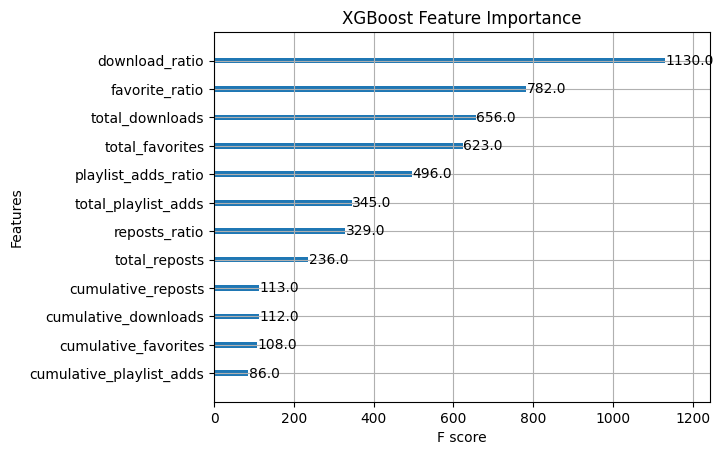

In [33]:
# Use a time-based split (80% train, 20% test without shuffling)
y=y = df['total_play30s']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# ---------------------------
# 4. Train XGBoost Regressor
# ---------------------------

model_xgb = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model_xgb.fit(X_train, y_train)

# ---------------------------
# 5. Evaluate the Model
# ---------------------------

# Predict on test data
y_pred = model_xgb.predict(X_test)

# Calculate Mean Squared Error and R² Score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Test MSE:", mse)
print("Test R² Score:", r2)

# ---------------------------
# 6. Plot Feature Importance
# ---------------------------

xgb.plot_importance(model_xgb)
plt.title("XGBoost Feature Importance")
plt.show()

In [22]:
df['total_play30s'].max() - df['total_play30s'].min()


991316

In [31]:
# %pip install shap

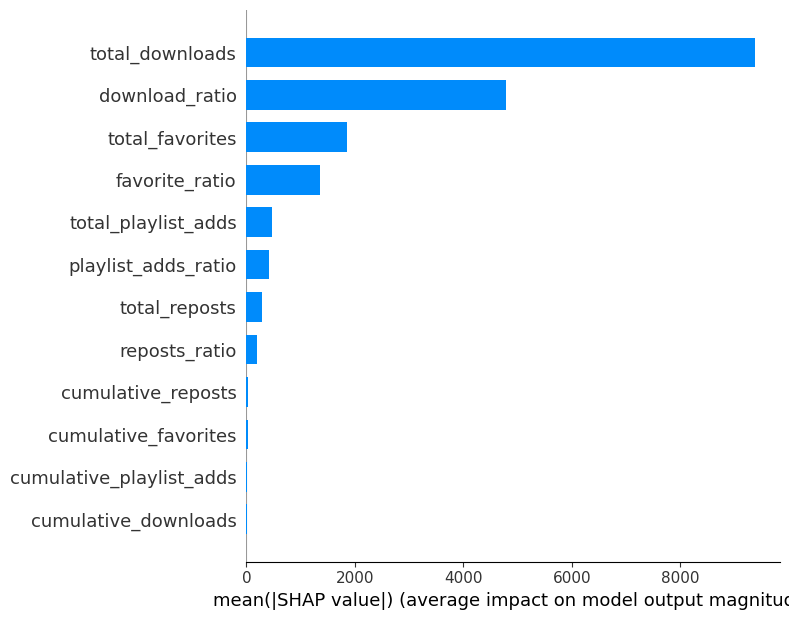

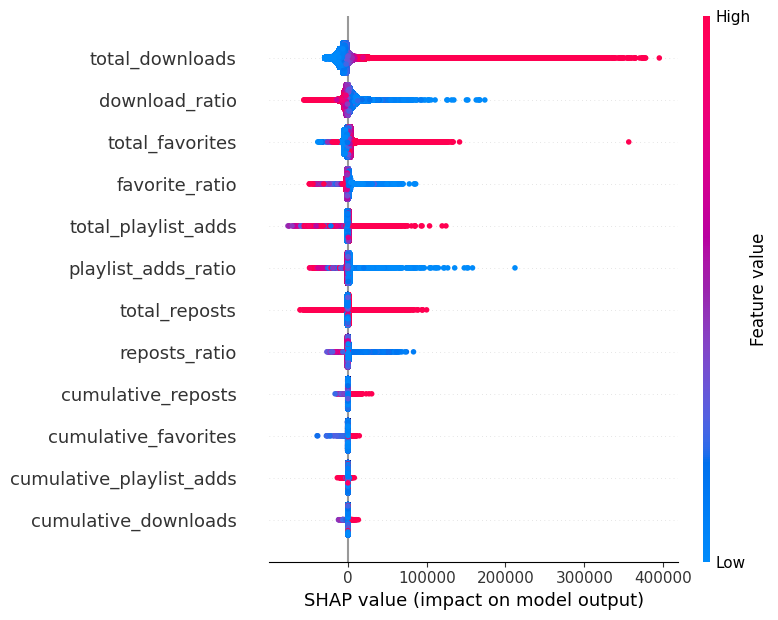

In [30]:
import shap
import xgboost as xgb



# Suppose 'model' is your trained XGBoost model, and X_train is your training DataFrame
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_train)

# Visualize the overall feature impact
shap.summary_plot(shap_values, X_train, plot_type="bar")

# A summary plot with positive/negative impacts
shap.summary_plot(shap_values, X_train)


In [40]:
%pip install --upgrade shap

Test MSE: 275463908.1637207
Test R² Score: 0.28670148769515713


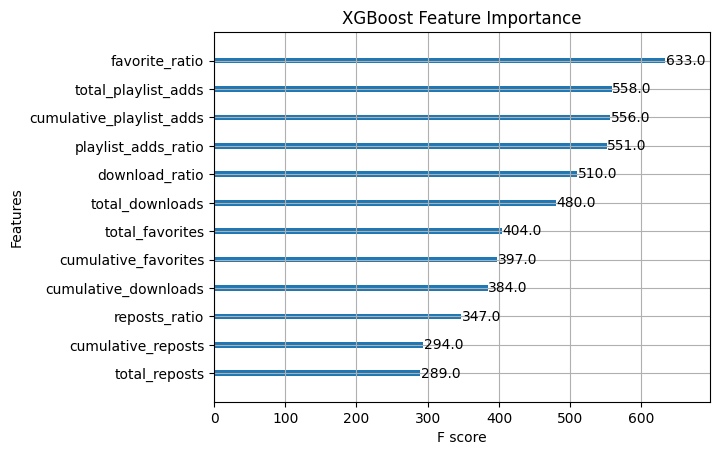

In [41]:
# Use a time-based split (80% train, 20% test without shuffling)
features = [
    'total_downloads',
    'total_favorites',
    'total_playlist_adds',
    'total_reposts',
    'download_ratio',
    'favorite_ratio',
    'playlist_adds_ratio',
    'reposts_ratio',
    'cumulative_downloads',
    'cumulative_favorites',
    'cumulative_reposts',
    'cumulative_playlist_adds'
]

X = df[features]
y = df['total_play30s_dff']

# Time-based train-test split (do not shuffle)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    shuffle=False
)



# ---------------------------
# 4. Train XGBoost Regressor
# ---------------------------

model_xgb = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model_xgb.fit(X_train, y_train)

# ---------------------------
# 5. Evaluate the Model
# ---------------------------

# Predict on test data
y_pred = model_xgb.predict(X_test)

# Calculate Mean Squared Error and R² Score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Test MSE:", mse)
print("Test R² Score:", r2)

# ---------------------------
# 6. Plot Feature Importance
# ---------------------------

xgb.plot_importance(model_xgb)
plt.title("XGBoost Feature Importance")
plt.show()

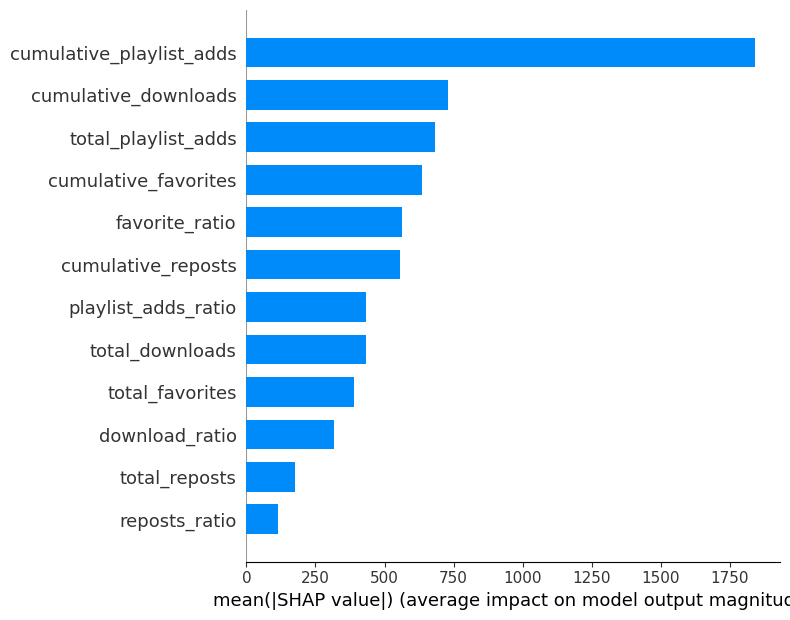

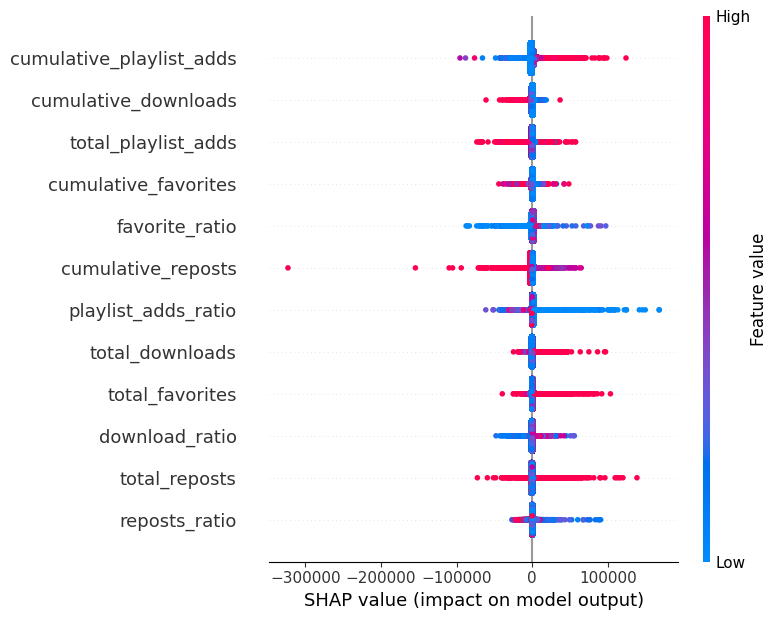

In [43]:
# Suppose 'model' is your trained XGBoost model, and X_train is your training DataFrame
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_train, check_additivity=False)


# Visualize the overall feature impact
shap.summary_plot(shap_values, X_train, plot_type="bar")

# A summary plot with positive/negative impacts
shap.summary_plot(shap_values, X_train)


# Visualization : Average Plays of the Top 10 hits for each region during 2 years

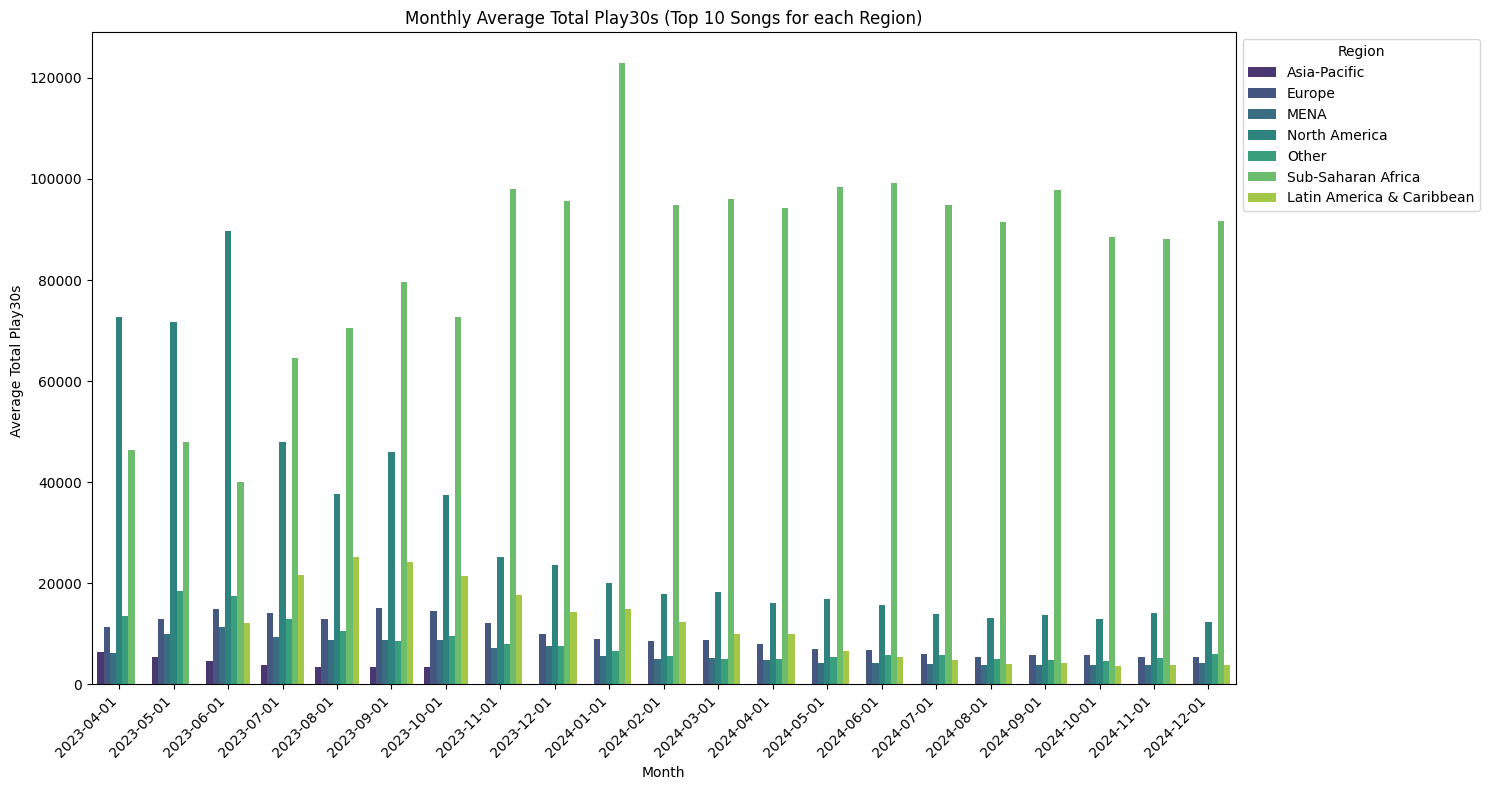

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Ensure 'month' is in datetime format
df["month"] = pd.to_datetime(df["month"])

# 1. Get the top 10 songs by total plays
song_totals = df.groupby(["music_id", "song_name", "artist_name"])["total_play30s"].sum()
top_10_songs = song_totals.nlargest(10).reset_index()["music_id"]
df_top_songs = df[df["music_id"].isin(top_10_songs)]

# 2. Create aggregated data for bars (average total_play30s by month and region)
df_bar = df_top_songs.groupby(["month", "region"], as_index=False)["total_play30s"].mean()

# 3. Create aggregated data for line (average total_downloads across all regions by month)
df_line = df_top_songs.groupby(["month", "region"], as_index=False)["total_downloads"].mean()

# 4. Create the plot
plt.figure(figsize=(15, 8))

# Plot grouped bar chart using Seaborn (bars by region)
bar_plot = sns.barplot(x="month", y="total_play30s", hue="region", data=df_bar, palette="viridis")

# 5. Format the x-axis as month names
ax = plt.gca()
# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # Show every 2 months
# ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))    # e.g., "Jan 2023"
plt.xticks(rotation=45, ha="right")
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


# Labels and title
plt.xlabel("Month")
plt.ylabel("Average Total Play30s ")
plt.title("Monthly Average Total Play30s (Top 10 Songs for each Region)")

# Adjust the legend: combine region legend from the bar and the line label
plt.legend(title="Region", bbox_to_anchor=(1, 1), loc="upper left")
plt.tight_layout()
plt.show()


# 10 Hidden Gem Songs that are future hits

In [69]:
# Define thresholds (adjust these as needed)
plays_threshold = df['total_play30s'].quantile(0.25)  # for instance, the lower quartile
playlist_threshold = df['cumulative_playlist_adds'].quantile(0.75)  # the upper quartile

# Filter for potential hidden gems
hidden_gems = df[
    (df['total_play30s'] < plays_threshold) &
    (df['cumulative_playlist_adds'] > playlist_threshold)&
    (df['region'] == 'Sub-Saharan Africa')
]

# Sort by cumulative playlist adds to see the most promising ones first
# Group by 'music_id' and get the row with the maximum cumulative_playlist_adds
df_hidden_gems = hidden_gems.loc[hidden_gems.groupby('music_id')['cumulative_playlist_adds'].idxmax()]
df_hidden_gems = df_hidden_gems.sort_values(by='cumulative_playlist_adds', ascending=False)
df_hidden_gems.head(10)


,month,music_id,geo_country,total_play30s,total_downloads,total_favorites,total_playlist_adds,total_reposts,song_name,artist_name,...,region,total_play30s_dff,download_ratio,favorite_ratio,playlist_adds_ratio,reposts_ratio,cumulative_playlist_adds,cumulative_downloads,cumulative_favorites,cumulative_reposts
145563,2024-12-01,23535622,KE,3052,771,16,81,2,Goodsin,olivetheboy,...,Sub-Saharan Africa,-113.0,0.252621,0.005242,0.026540,0.000655,359848,3178747,80545,2468
408832,2024-12-01,23176134,CM,3649,424,12,65,1,Butta My Bread,JZyNo,...,Sub-Saharan Africa,602.0,0.116196,0.003289,0.017813,0.000274,283527,2989692,81252,2632
223508,2024-12-01,19291237,TZ,3044,857,19,261,0,Daddy Wey Dey Pamper,Moses Bliss,...,Sub-Saharan Africa,-249.0,0.281537,0.006242,0.085742,0.000000,214255,1813116,46678,3266
372276,2024-10-01,19767382,SL,3157,851,22,139,0,Call of Duty,Zinoleesky,...,Sub-Saharan Africa,48.0,0.269560,0.006969,0.044029,0.000000,155671,1655376,32876,1054
9131,2024-12-01,23183008,NG,3029,318,18,88,1,Aseda,Nacee,...,Sub-Saharan Africa,-2028.0,0.104985,0.005943,0.029052,0.000330,154023,1537304,38865,2603
197504,2024-11-01,9998921,TZ,3802,873,20,167,0,Too Faithful,Moses Bliss,...,Sub-Saharan Africa,168.0,0.229616,0.005260,0.043924,0.000000,148109,985765,23528,947
589019,2024-12-01,21519957,BJ,3866,806,20,77,0,Personal,Zinoleesky,...,Sub-Saharan Africa,119.0,0.208484,0.005173,0.019917,0.000000,147134,1849805,34297,1126
337723,2024-12-01,23545792,CM,3913,436,17,27,0,Many Things,Zinoleesky,...,Sub-Saharan Africa,379.0,0.111423,0.004344,0.006900,0.000000,144986,2359622,43008,2040
517768,2024-12-01,6991193,ZA,3104,1153,52,112,2,Hope,XXXTENTACION,...,Sub-Saharan Africa,-4.0,0.371456,0.016753,0.036082,0.000644,124840,1320300,54446,1662
165323,2024-12-01,6779159,CM,3347,551,13,67,0,F.N,Lil TJay,...,Sub-Saharan Africa,9.0,0.164625,0.003884,0.020018,0.000000,121360,1227520,53179,1798


In [ ]:
df['region' == 'Sub-Saharan Africa']